# Homework 3 - Find the perfect place to stay in Texas!

### Claudio Battiloro, Giacomo Lo Cascio, Theodoros Sofianos

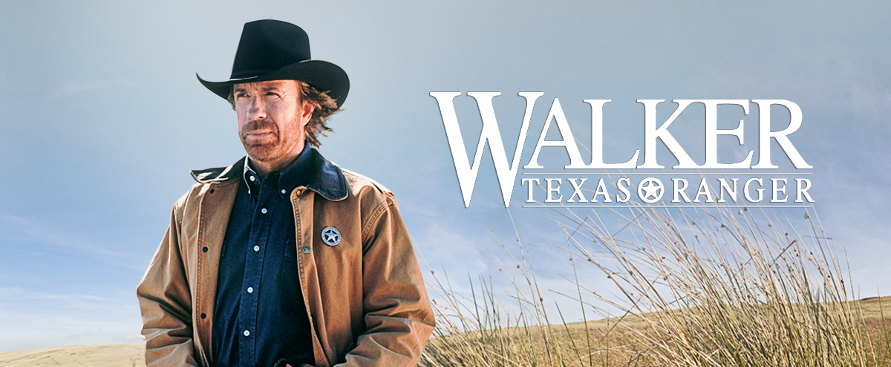

The homework consists in analyzing the text of Airbnb property listings in Texas and building a search engine.



First of all, we need to import libs:


In [22]:
import pandas as pd
import pickle

We've choosen to run the analysis creating a function for every request. We've done this in order to make the code clearier and easier to understand. Of course, it's also permits to modify single requestes without changing the entire code and don't worrying about memory issues. All this funtions are stored in the following .py:

In [2]:
import Hw3_lib as h


In [3]:
# Bonus cell in case the reader wanna open this files using pickle(of course directories have to be changed).
with open("inverted_index2","rb") as f:
    inverted_index2 = pickle.load(f)
with open("vocabulary","rb") as f:
    vocabulary = pickle.load(f)
with open("inverted_index","rb") as f:
    inverted_index = pickle.load(f)

## - Create documents

First of all we need to build our corpus of documents. 

In order to do this, we are asked to split the dataset in a .tsv file for each row. As explained in the "documentation" of our lib, we can use the following function. The function has a pre-setted path in which it will save the docs, but, of course, it can be easily changed.

In [24]:
path = r"D:\Claudio\Uni\M 1° anno Sapienza\AMDS\Homeworks\Hw3\Datasets\Airbnb_Texas_Rentals.csv"
number_of_docs = h.csv_to_tsv(path_of_the_doc_to_convert = path)

The function returns the number of doc, this will be useful later.

Now we have the aforementioned .tsv file we need.

## - PreProcessing

Before proceeding with the definition of a search engine, we need to PreProcess the documents. In order to do this we decided to load the datasets and preprocess it entirely with functions we implemented and explained in our lib. The "PreProcessing" function implements:
- the Tokenizing of the documents
- the removal of stop-words
- the stemming of words
- the removal of non-ASCII characters
- the removal of punctuation
- the replacing of numbers with their literal representation
- the conversion of words in lower case

Of course, the same functions can be applied also on the single .tsv files by simply loading them with Pandas, but is drastically less efficient, becouse in our way it's possible to vectorize the procedure by using "apply" function, instead of implements a loop.

(Aris told us we can do this, also becouse the same function we wrote could be used in both way, .tsv or .csv)

In [25]:
data = pd.read_csv(path, engine = "python")
pdata = data.apply(h.preProcessing, axis = 1)

Now that we have our preprocessed dataset, we just need to save each record as .tsv. We can use the same function as before, but passing to the function the df and not a path.

In [9]:
h.csv_to_tsv(pdata = pdata)

18260

At this point, all documents are saved, preprocessed and ready to be used in a search engine!

## - $\mathbf{1^{st}}$ Search Engine: Conjunctive query

At this moment, we narrow out interest on the description and title of each document. It means that the first Search Engine will evaluate queries with respect to the aforementioned information.

### Vocabulary

Before building the index, we create a file named vocabulary, as a dictionary, that maps each word to an integer (term_id). We do this with the following function, that takes the number of docs and the path where they're saved. This will be useful later. Moreover, the function saves the vocabulary as a "pickle" to avoid its creation for any different application on the same corpus.

In [10]:
ppath = r"D:\Claudio\Uni\M 1° anno Sapienza\AMDS\Homeworks\Hw3\ptsv\\"
vocabulary = h.create_vocabulary(number_of_docs, ppath)

### Inverted Index

Now we can build our first inverted index. In order to improve efficiency within respect to the code we wrote (just look at the lib to understand why), it will be a dictionary of this format:

```
{
term1:[document_1, document_2, document_4],
term2:[document_1, document_3, document_5, document_6],
...}

```

We can do this with the following function, that takes the number of documents ad the path where they're saved. Moreover, the function saves the vocabulary as a "pickle" to avoid its creation for any different application on the same corpus.

In [12]:
inverted_index = h.create_inverted_index(number_of_docs, ppath)

The inverted index is saved on the repo.

### The Search Engine

Since we are requested to deal with conjunctive queries (AND), each of the returned documents should contain all the words in the query. The final output of the query must return, if present, the following information for each of the selected documents:

- Title
- Description
- City
- Url

To do this, we implemented a function that returns the results taking the inverted index and the path where non preprocessed documents are saved. We present some examples, in order to show the properties of the search engine:


In [6]:
np_path = r"D:\Claudio\Uni\M 1° anno Sapienza\AMDS\Homeworks\Hw3\tsv\\"
_,_,_,res = h.first_search_engine(inverted_index, np_path)
if type(res) != str : # If there are results ( look at the lib)
    display(res.style.hide_index())

Insert your query:
new luxury house


TITLE,DESCRIPTION,CITY,URL
Phoenix Rising... A Few Steps to the shores of Surfside Beach!,Looking for a newer vacation home with a great kitchen and 4 (yes 4!) decks to see all angles of the Gulf? This is your spot to book then! Excellent location just a couple houses down from the beach walkway on a quiet side street in the community of Surfside Beach. Enjoy the seashell covered beach while basking in the sun all day and then stroll back to enjoy a fabulous meal together on the large main level deck or at the dining table. 3 large bedrooms are all outfitted with a Queen size bed with luxury hotel grade linens. The upstairs Master and second Mater bedrooms each have their own private full bathrooms and private decks. Bedroom #3 is the largest offering some extra room to throw a sleeping bag or air mattress on the floor for the kiddies and still not be cramped. 3 full bathrooms are in this sea side beach home.\r It is easy to enjoy all the close-by amenities Surfside Beach has to offer including multiple restaurants several bars and even a crabbing pier located across the street!\r **All reservations include $ liability protection and $10 000 damage insurance - No Security Deposit Required!\r **NOTE: Reservations for Spring Break (month of March) Memorial Day weekend Fourth of July Labor Day weekend Thanksgiving and Christmas and New Years all require a minimum 4 day reservation. Reservations between June 1st and September 1st all require a minimum 3 day reservation.\r **Absolutely No Prom or Graduation parties permitted please.\r THE 979 VACATION PROPERTY SERVICES ADVANTAGE:\r This property is 979 Certified. All photos amenities calendar and rates are 100% accurate to the best of our knowledge. We ensure our homes are completely cleaned after each guest stay ensuring your stay is nothing short of spectacular. In addition all of our homes feature hotel-quality/high thread count on all sheets bedding and bath towels. When you rent a 979 home you'll also receive the comforts of home with a starter supply of shampoo shower gel conditioner toilet paper and paper towels dishwasher and clothes washer pods. We want your stay to be as easy as you do and we make every effort to delight.\r EASY CHECK-IN:\r And we make it easy to stay with us! Access the home with a unique lock code that we give only to you via text and email.\r 979 VACATION PROPERTY SERVICES:\r All 979 Vacation Property Services rental home follow local and state tax rules. Each reservation includes applicable taxes a cleaning fee and a Property Damage Protection policy for your peace of mind.,Freeport,https://www.airbnb.com/rooms/19406684?location=Angleton%2C%20TX
Luxury Carriage House-Travis Heights,Welcome to The Hideaway Carriage House a private and secluded luxury experience located in coveted Travis Heights right in the heart of South Congress. Why choose the Hideaway? Premier location high end design delights luxury amenities and a tranquil and private setting. Enjoy the utmost in privacy and seclusion. Premier Location! Only 4 short blocks to vibrant South Congress shopping and restaurants. And Stacy Park/Pool and wooded walking/biking trails are just a few blocks away! At The Hideaway Carriage House you are surrounded by a carefully curated mix of bespoke antique modern and custom furnishings and eclectic art work. Luxury amenities including bedding linens from Frette and Restoration Hardware furnishings from high end designers including Horchow and Restoration Hardware and gourmet espresso and complementary drinks to elevate your stay to a lush and relaxing boutique experience. Details Details Details!: Perks extras and amenities include Turkish robes moisturizers tooth brush and shaving kits. All brand new furnishings Kitchen equipment Entertainment system and new construction. Amenities include luxurious Egyptian cotton bedding new Beautyrest plush pillowtop mattress and fully equipped kitchen. The Hideaway interior was created by the owner who is a design en

We implemented some features to catch searchs without results:

In [7]:
_,_,_,res = h.first_search_engine(inverted_index, np_path)
if type(res) != str : # If there are results ( look at the lib)
    display(res.style.hide_index())

Insert your query:
tre tigri sopra tre tigri
Your search did not bring results. Do you wanna try again? [y/n]
f**K you!
You can choose [y/n] !
y
Insert your query:
brand new house with garden


TITLE,DESCRIPTION,CITY,URL,AVERAGE_RATE_PER_NIGHT,BEDROOMS_COUNT
Private Rm/Bath @ the Gold House!,This unique private guest room at the Gold House offers the amenities of home in a city full of things to do! The entire downstairs living room kitchen and dining area is open to guests. Come on down to SA town and experience Texan hospitality for yourself! Please note: there is a second guest room at the Gold house so if this listing is booked do check with me to see if the second room is available! Thanks for your interest! Cute House: It's a private room upstairs with a full bed small desk walk-in closet Ironing Board and en suite bathroom. The window has a nice view of the back yard and wooded easement. The back yard is large with a little garden in the back. The kitchen was recently renovated with nice granite counter tops and new appliances. Also there is a brand new running/hiking trail one mile away. Parking is safe and free in the form of my driveway. More than Two People? No problem: There is a second guestroom in the loft with a full bed that can be reserved via my other listing. http://airbnb.com/rooms/826725 Breakfast/Snacks: The living room/dining room/patio/kitchen are all fair game for guests. Breakfast is provided by way of oatmeal and any items found on the counter (Hot tea and coffee too). Four-Legged Friends: I do have two wonderful dogs (lab and husky) but don't worry they aren't allowed upstairs. They stay outside during the day and sleep in their beds downstairs at night. They are both full of sugar - but if you have a fear of dogs then this place is not for you(URL HIDDEN) Location: It is literally right next to a brand new grocery store but you wouldn't know it from the back yard. It is 10-15 minutes from La Cantera - the gorgeous outdoor shopping mall. As well as Six Flags Fiesta Texas and UTSA. It is 5-10 minutes from the medical center area where all the hospitals are. It is 3 miles from IH-10 which is the main highway to get to downtown where the Riverwalk is (about 20 minutes by car). Airport - about 15-20 minutes away. Things to look up for your trip regardless of whether you choose the Gold House for your stay (we want you to have fun!): In San Antonio... - The Riverwalk - Market Square - The Spanish Missions (Includes the Alamo of course...you can rent bikes to explore all of them!) - Six Flags Fiesta Texas Theme Park - Sea World Theme Park - Morgan's Wonderland (Special Needs Theme Park) - San Antonio Botanical Gardens - San Antonio Zoo Within an Hour of San Antonio... - Schlitterbahn Water Park (Amazing rides Bring Food and Free Parking) - Natural Bridge Caverns (wondrous caves to stay cool) - Natural Bridge Wildlife Ranch (African Safari Texas Style) - Gruene Texas (adorable hill country town with shopping and tubing on the river) The entire downstairs! Safe neighborhood - within walking distance to a grocery store! Bus stop is about a 10 minute walk from the front door. Checkout is more flexible if there are no guests arriving the same night you're leaving.,San Antonio,https://www.airbnb.com/rooms/1284796?location=Bulverde%2C%20TX,$40,1
BRAND NEW HOME EXQUISITE DECORATION LARGE GARDEN,Brand new house with exquisite decoration. We have two indoor parking spaces and three exterior parking spaces in case you are traveling by car. The beds are orthopedic which provides a comfortable rest. For us cleaning is an essential point in the house so feel totally safe. The house has been designed and decorated to satisfy the needs of families business trips and relaxation time. We hope to make your stay an unforgettable experience!,Spring,https://www.airbnb.com/rooms/15285127?location=Conroe%2C%20TX,$149,4
Colorful Garden Home plus Private Studio Apartment,Natural beauty and great art make this clean comfortable house and attached apartment special. New appliances and fixtures wood + tile floors and fresh-bright colors make it cheery and relaxing. Two great kitchens brand new quality beds a sunny patio enc

## - $\mathbf{2^{nd}}$ Search Engine: Cosine Similarity between Query and Documents Ranking

In the new Search Engine, given a query, we want to get the top-k (the choice of k it's up to the user) documents related to the query. In particular:

- Find all the documents that contains all the words in the query (as before...).
- Sort them by their similarity with the query
- Return in output k documents, or all the documents with non-zero similarity with the query when the results are less than k. We must use a heap data structure for maintaining the top-k documents.

Note that there is a difference from this and what we did in the class. Here we are returning documents that contain all the query terms.

### Inverted Index with the TFIDF

Our second Inverted Index is of this format:

```
{
term1:[(document1, tfIdf_{term,document1}), (document2, tfIdf_{term,document2}), (document4, tfIdf_{term,document4}), ...],
term2:[(document1, tfIdf_{term,document1}), (document3, tfIdf_{term,document3}), (document5, tfIdf_{term,document5}), (document6, tfIdf_{term,document6}), ...],
...}
```

Practically, for each word we get the list of documents in which it is contained in, and the relative *tfIdf* (term frequency–inverse document frequency) score.

To build this structure, we have to compute before the IDF of each term with the following function that takes the term, the first inverted index and the number of documents. We decide to store the IDF in a list.

Remember that the *idf* of a term is a measure of the importance of the term in the entire corpus and it's defined as:

$ \mathbf{idf_{i} =  \log \frac{|D|}{|\{d: i \in d\}|}} $

where $|D|$ is the number of the documents in the corpus, and the denominator is the number of documents that contain the term $i$.


In [7]:
idfi = []
for term in vocabulary:
    idfi.append(h.IDFi(term,inverted_index,number_of_docs)) 

Now that we have the list of IDF, it's possible to compute the second inverted index with the following function that takes the number of documents, the path where thery're saved, the vocabulary and the list of IDF. Moreover, the function saves the vocabulary as a "pickle" to avoid its creation for any different application on the same corpus.

Remember that the *tf* of a term within respect a document is defined as :

$ \mathbf{tf_{i,j} = \frac{n_{i,j}}{|d_j|}}$

where $n_{i,j}$ is the number of occurences of the term $ i $ in the document $j$, and the denominator $ |d_j| $ is the dimension of the document $j$ expressed as the number of words it contains.


In [36]:
inverted_index2 = h.create_inverted_index_with_TFIDF(number_of_docs, ppath, vocabulary, idfi)

The inverted index is saved on the repo.

## The Search Engine

To answer the request, as scoring function we use the Cosine Similarity with respect to the *tfIdf* representations of the documents.

The Search Engine returns a list of documents, ranked by their Cosine Similarity with respect to the query.

More precisely, the output contains:

- Title
- Description
- City
- Url
- The similarity score of the documents with respect to the query


Remember that the Cosine Similarity between two vectors $\mathbf{v_1}$ and $\mathbf{v_2}$ is defined as:

$\text{similarity} = \cos(\theta) = {\mathbf{v_1} \cdot \mathbf{v_2} \over \|\mathbf{v_1}\| \|\mathbf{v_2}\|}.$

Another meaningful way to look at the formula is :

$\frac {\sum_{k=1}^{n} \mathbf{v_1}(k)\mathbf{v_2}(k)} {\sqrt{\sum_{k=1}^{n} \mathbf{v_1}(k)^2}  \sqrt{\sum_{k=1}^{n} \mathbf{v_2}(k)^2}}$

Vectors belong to $\mathbb{R}^\mathbf{n}$  and, in our case $n = \{\text{number of distinct words in the query}\} \bigcup  \{\text{number of distinct words in document}\}$.
This dimension can be very huge, but from the second equation it's easy to understand that nonzero contributions in the sum at the numerator are given by the words that are both in the query and in the document. 
With this "tip", we can improve the computational time and work in dimension $\mathbb{R}^\mathbf{m}$, where $m = \{\text{number of distinct words in the query}\} \bigcap  \{\text{number of distinct words in document}\}$.

In our implementation we decided, due to the code structure chosen, to work in a slightly suboptimal way with vectors $ \in \mathbb{R}^\mathbf{p} $ , where $p = \{\text{number of distinct words in the query}\} $.

The search engine is implmented through a function that takes the two inverted indices, the vocabulary, the number of documents, the path where they're saved, the list of IDFI, and $k$, that sets how many results user wants (default $k=10$), obtained through an heap structure.

In [11]:
np_path = r"D:\Claudio\Uni\M 1° anno Sapienza\AMDS\Homeworks\Hw3\tsv\\"
h.second_search_engine(inverted_index, inverted_index2, vocabulary,  np_path, idfi, k = 5)

Insert your query:
brand house sea


SCORES,TITLE,DESCRIPTION,CITY,URL
0.940757,New House with Pond View & Pool,Sea Foam - Is the Perfect Family Beach House - Sleeps 12 Comfortably + Kid-Friendly. Fish off the balcony or enjoy the view. Conveniently located on 11th street. Very close to the beach local stores and restaurants. House is Brand NEW!,Port Aransas,https://www.airbnb.com/rooms/11451221?location=Corpus%20Christi%2C%20TX
0.881474,Private Rm/Bath @ the Gold House!,This unique private guest room at the Gold House offers the amenities of home in a city full of things to do! The entire downstairs living room kitchen and dining area is open to guests. Come on down to SA town and experience Texan hospitality for yourself! Please note: there is a second guest room at the Gold house so if this listing is booked do check with me to see if the second room is available! Thanks for your interest! Cute House: It's a private room upstairs with a full bed small desk walk-in closet Ironing Board and en suite bathroom. The window has a nice view of the back yard and wooded easement. The back yard is large with a little garden in the back. The kitchen was recently renovated with nice granite counter tops and new appliances. Also there is a brand new running/hiking trail one mile away. Parking is safe and free in the form of my driveway. More than Two People? No problem: There is a second guestroom in the loft with a full bed that can be reserved via my other listing. http://airbnb.com/rooms/826725 Breakfast/Snacks: The living room/dining room/patio/kitchen are all fair game for guests. Breakfast is provided by way of oatmeal and any items found on the counter (Hot tea and coffee too). Four-Legged Friends: I do have two wonderful dogs (lab and husky) but don't worry they aren't allowed upstairs. They stay outside during the day and sleep in their beds downstairs at night. They are both full of sugar - but if you have a fear of dogs then this place is not for you(URL HIDDEN) Location: It is literally right next to a brand new grocery store but you wouldn't know it from the back yard. It is 10-15 minutes from La Cantera - the gorgeous outdoor shopping mall. As well as Six Flags Fiesta Texas and UTSA. It is 5-10 minutes from the medical center area where all the hospitals are. It is 3 miles from IH-10 which is the main highway to get to downtown where the Riverwalk is (about 20 minutes by car). Airport - about 15-20 minutes away. Things to look up for your trip regardless of whether you choose the Gold House for your stay (we want you to have fun!): In San Antonio... - The Riverwalk - Market Square - The Spanish Missions (Includes the Alamo of course...you can rent bikes to explore all of them!) - Six Flags Fiesta Texas Theme Park - Sea World Theme Park - Morgan's Wonderland (Special Needs Theme Park) - San Antonio Botanical Gardens - San Antonio Zoo Within an Hour of San Antonio... - Schlitterbahn Water Park (Amazing rides Bring Food and Free Parking) - Natural Bridge Caverns (wondrous caves to stay cool) - Natural Bridge Wildlife Ranch (African Safari Texas Style) - Gruene Texas (adorable hill country town with shopping and tubing on the river) The entire downstairs! Safe neighborhood - within walking distance to a grocery store! Bus stop is about a 10 minute walk from the front door. Checkout is more flexible if there are no guests arriving the same night you're leaving.,San Antonio,https://www.airbnb.com/rooms/1284796?location=Bulverde%2C%20TX
0.881474,Private Rm/Bath @ the Gold House!,This unique private guest room at the Gold House offers the amenities of home in a city full of things to do! The entire downstairs living room kitchen and dining area is open to guests. Come on down to SA town and experience Texan hospitality for yourself! Please note: there is a second guest room at the Gold house so if this listing is booked do check with me to see if the second room is available! Thanks for your interest! Cute House: It's a private room upstairs with a full bed small des

## - Our Search Engine

Now it's our turn. Airbnb wants us in their team, but they need the best idea ever on how to rank the houses based on the queries of their users.

In this scenario, a single user can give in input more information than the single textual query, so we need to take into account all this informations, and think a creative and logical way on how to answer at user's requests.

Practically:

The user will give us for sure a text query. As a starting point, get the query-related documents by exploiting the first search engine.

Once we have the documents, we need to sort them according to our new score. In this step we won't have anymore to take into account the title and description of the documents, we must use only the remaining variables inthe dataset. We must use again a heap data structure for maintaining the top-k documents.

### The score function

To explain what we implemented, it's useful to start by the final formula and then analyze it.
But first,let's define our variables:

- $s$ = the average rate per night of the current document
- $\widetilde{s}$ = the preffered rate chosen by the user
- $b$ = the bedrooms count of the current document
- $\widetilde{b}$ = the preferred number of bedrooms chosen by user
- $c$ = the city of the current documents
- $\widetilde{c}$ = the preferred city chosen by user

At this point we can define
$\text{score} = f(s, \widetilde{s}, b, \widetilde{b}, c, \widetilde{c},) = \frac{W}{\alpha + \beta + \omega}(\alpha \cdot g(s, \widetilde{s}) + \beta\cdot h(b, \widetilde{b}) + \omega \cdot u(c, \widetilde{c}))$

From this formula it's clear that the final score of the doc is given by a linear combination between three function, each one of them is related to a pair of variables of interest. Moreover, the score is in the range $[0,W]$ due to the normalization factor at the start and (we'll see) that every function is bounded in $[0,1]$. 

Now we can better understand how it works by analyzing the three aforementioned function:

- $g(s, \widetilde{s}) = \begin{cases} e^{-\frac{s}{\widetilde{s}}} & \mbox{if } s\mbox{ is between 0 and } \widetilde{s} \\ 0 & \mbox{otherwise }\end{cases} $

Let's see how this function looks like (suppose fixed $\widetilde{s} = 20$):

In [91]:
import importlib
importlib.reload(h)

<module 'Hw3_lib' from 'C:\\Users\\claba\\Desktop\\Python Lavori Congiunti AMDS FDS\\AMDS Works\\Homework 3\\Hw3_lib.py'>

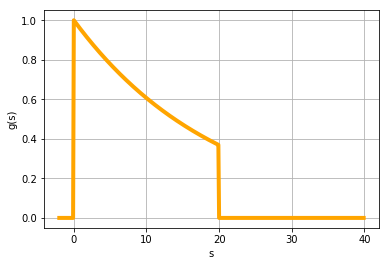

In [72]:
h.g_fun(20)

As we can see, if the user chooses a rate, an house with that rate contributes to the total score with a factor of $\alpha \cdot \frac{1}{e}$ and houses with lower price contributes with higher factors (the max score $\alpha$ is ideally given by a zero dollars house). This function is clearly bounded in $[0,1]$

- $h(b,\widetilde{b}) = min\{\frac{b}{\widetilde{b}}, \frac{\widetilde{b}}{b} \} $

Let's see how this function looks like (suppose fixed $\widetilde{b} = 4$):

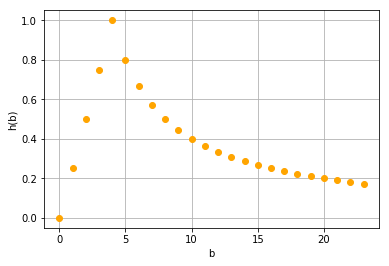

In [81]:
h.h_fun(4)

As we can see, if the user chooses a number of bedrooms, an house with that number of bedrooms contributes to total score with a factor $\beta$ and the score goes down for houses that have more bedrooms ($ \propto 1/x$) than necessary lower than houses that have less bedrooms ($ \propto x $) than necessary ( we thought that is better have more beds than less).This function is clearly bounded in $[0,1]$ for number of bedrooms $ > 0$ ( so always, in our case).

- $u(c, \widetilde{c}) = 1 - \frac{d(c, \widetilde{c})}{d_{max}} $, where $d(\cdot)$ computes the distance between the two cities that takes as arguments and $d_{max}$ is a normalization factor chosen, in our case, as the distance between the two most distant points in Texas. In this way, we guarantee that this function is bounded in $[0,1]$.

Let's see how this function looks like:

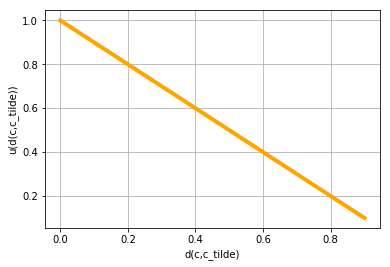

In [77]:
h.u_fun()

As we can see, if the user choses a city, an house that is in that city contributes to total score with a factor $ \omega$ (not totally true, becouse the distance is computed between the centre of the city and the address of the house) and the score linearly goes down while distance grows.

Of course a key role is played by the parameters $ \alpha,\beta,\omega $ that are the weights of the related features. In the example we present we've choosen :
- $ W = 100 $
- $\alpha = 5 $
- $ \beta = 4  $
- $ \omega = 3 $

The search engine is implemented through a function that takes the inverted index, the path where documents are saved and the number $k$ of document in the results (still obtained using a max heap structure).

In [11]:
h.our_search_engine(inverted_index,np_path,10)

Insert your query:
new house
How much would you like to spend at most?
25
How many bedrooms do you prefer? 
1
In which city would you rather be? 
houston


SCORE,TITLE,DESCRIPTION,CITY,URL,AVERAGE_RATE_PER_NIGHT,BEDROOMS_COUNT
82.4009,Fabulous and new room with backyard,This room is the new edition to the house. Brand new awesome therapeutic bed with a new flat television with cable and movie channels. Nice clean kitchen with a nice relaxing backyard and good for grilling too.Guest must add a photo b4 reservation. I have another Airbnb Listing: https://www.airbnb.com/rooms/6164806,Houston,https://www.airbnb.com/rooms/8519026?location=Atascocita%2C%20TX,$22,1
79.8437,New House Guest Room,Space will make you feel like you are in India/Thailand. Very calm colors and tones. Quiet location but 10-15 min drive to downtown or Metro rapid bus. Food & shopping centers literally walking distance. Netflix included.,Austin,https://www.airbnb.com/rooms/11006655?location=Buda%2C%20TX,$19,1
77.3287,Private room - newly renovated home,Room available in 2 000 sq foot home that's just minutes south of Austin. House is in a quiet neighborhood and sits on an acre. If you enjoy a quiet atmosphere and are an animal lover this could be for you!,Buda,https://www.airbnb.com/rooms/10327809?location=Buda%2C%20TX,$22,1
76.3678,Spacious Room Near Ft. Sam Randolph and Airport.,Just north the busy street of Walzem and where you can find everything to include San Antonio's IN-N-OUT this house is a brand new 3 bedroom 2.5 bathroom in the perfect location. The inner 410 loop and I-35 junction is literally a straight shot west with easy access to both and only 5 miles from Randolph and 7 miles from Fort Sam Houston and 8 miles from the San Antonio Airport.,San Antonio,https://www.airbnb.com/rooms/16568668?location=Cibolo%2C%20TX,$22,1
76.3678,Spacious Room Near Ft. Sam Randolph and Airport.,Just north the busy street of Walzem and where you can find everything to include San Antonio's IN-N-OUT this house is a brand new 3 bedroom 2.5 bathroom in the perfect location. The inner 410 loop and I-35 junction is literally a straight shot west with easy access to both and only 5 miles from Randolph and 7 miles from Fort Sam Houston and 8 miles from the San Antonio Airport.,San Antonio,https://www.airbnb.com/rooms/16568668?location=Bulverde%2C%20TX,$22,1
75.9892,New room. Turquoise calm colors.,Brand new bed in a brand new house. Memory foam so you will fall fast asleep. Very calm colors and tones. Quiet location but 10-15 min drive to downtown or Metro rapid bus 20-22 mins.,Austin,https://www.airbnb.com/rooms/11421176?location=Buda%2C%20TX,$24,1
63.6048,BIG gorgeous renovated 1BR; Central locale; Views!,Newly renovated w/ incredible views from large private deck in ideal central location convenient to everything. Hip neighborhood of restaurants bars coffee house and shops. On Bayou trails park entrance 3 blocks. Historic 1800s exterior & stylish modern sunny open-concept interior w gorgeous mid-century furniture. Private entrance; reserved driveway; lighted walkway and stairs. Shared laundry. Grocery general stores close. Walk downtown theater district light rail. I45 or I10 4 blocks.,Houston,https://www.airbnb.com/rooms/16924285?location=Alvin%2C%20TX,$89,1
63.6048,BIG gorgeous renovated 1BR; Central locale; Views!,Newly renovated w/ incredible views from large private deck in ideal central location convenient to everything. Hip neighborhood of restaurants bars coffee house and shops. On Bayou trails park entrance 3 blocks. Historic 1800s exterior & stylish modern sunny open-concept interior w gorgeous mid-century furniture. Private entrance; reserved driveway; lighted walkway and stairs. Shared laundry. Grocery general stores close. Walk downtown theater district light rail. I45 or I10 4 blocks.,Houston,https://www.airbnb.com/rooms/16924285?location=Atascocita%2C%20TX,$89,1
63.6048,BIG gorgeous renovated 1BR; Central locale; Views!,Newly renovated w/ incredible views from large private deck in ideal central location convenient to everything. Hip neighborhood of restaurants bars coffee house and shops. On Bayou trails pa

As we can see the results are pretty consistent. Let's make another example trying to insert a weird city:

In [13]:
h.our_search_engine(inverted_index,np_path,10)

Insert your query:
house with garden
How much would you like to spend at most?
100
How many bedrooms do you prefer? 
2
In which city would you rather be? 
cicciano
There is no city in Texas with this name or the service timed out, reinsert please:
austin


SCORE,TITLE,DESCRIPTION,CITY,URL,AVERAGE_RATE_PER_NIGHT,BEDROOMS_COUNT
88.245,Stay at an architect's gorgeous home and garden!,A beautiful modern home surrounded by a beautiful garden and full of natural light! Designed by an architect this house is wonderfully furnished. Just miles from downtown and minutes away from the Arboretum and Domain shopping centers this is the perfect spot for a weekend getaway or a business trip.,Austin,https://www.airbnb.com/rooms/18998883?location=Austin%2C%20TX,$60,2
88.245,Stay at an architect's gorgeous home and garden!,A beautiful modern home surrounded by a beautiful garden and full of natural light! Designed by an architect this house is wonderfully furnished. Just miles from downtown and minutes away from the Arboretum and Domain shopping centers this is the perfect spot for a weekend getaway or a business trip.,Austin,https://www.airbnb.com/rooms/18998883?location=Cedar%20Park%2C%20TX,$60,2
86.4037,Tex-Mex Casita close to Pearl!,Cute hideaway cottage only 1 mile from the Pearl District. Nestled between Government Hill and Dignowity Hill historic districts our little Tex-mex casita is just a 15 minute walk to the Pearl or Dignowity Hill beer gardens and only 2 miles from the Alamo! You get the privacy of an entire house but at the price of a room- perfect for artsy budget travelers. Live like a local in this urban casita tastefully decorated with Mexican folk art.,San Antonio,https://www.airbnb.com/rooms/12220430?location=Alamo%20Heights%2C%20TX,$59,2
84.8279,Peaceful home near airport & downtown,Our home is filled with warmth from lots of natural light. The original wood floors and earthy decor create a peaceful environment for anyone. We have a big backyard & garden that is very kid and pet friendly as well as many toys to share in our boys room. The house is 5 minutes away from the airport as well as 10 minutes away from downtown. We are in the middle of San Antonio which is a great location for accessing all types of fun.,San Antonio,https://www.airbnb.com/rooms/19014109?location=Converse%2C%20TX,$66,2
77.9973,Lovely queen bedroom in NW Austin,My house is close to Lakeline Mall highways and the toll road restaurants grocery stores hike and bike trails parks Lake Travis. Youâ€™ll love my home because of the quiet safe neighborhood the light the really comfy queen size bed the sunny kitchen the gardens hammocks and hot tub. My place is good for couples solo adventurers business travelers and families (with kids). I also have 2 other rooms so if you need more beds please check out my other listings too.,Austin,https://www.airbnb.com/rooms/14821566?location=Cedar%20Park%2C%20TX,$32,1
77.9947,Beautiful queen bedroom in NW Austin,My house is close to Lakeline Mall highways and the toll road restaurants grocery stores hike and bike trails parks Lake Travis. Youâ€™ll love my home because of the quiet safe neighborhood the light the really comfy queen size bed the sunny kitchen the gardens hammocks and hot tub. My place is good for couples solo adventurers business travelers and families (with kids). I also have 2 other rooms so if you need more beds please check out my other listings too.,Austin,https://www.airbnb.com/rooms/16755710?location=Cedar%20Park%2C%20TX,$32,1
76.3844,Beautiful king bedroom in NW Austin,My house is close to Lakeline Mall highways and the toll road restaurants grocery stores hike and bike trails parks Lake Travis. Youâ€™ll love my home because of the quiet safe neighborhood the light the really comfy king size bed the sunny kitchen the gardens hammocks and hot tub.. My place is good for couples solo adventurers business travelers and families (with kids). I also have 2 other rooms so if you need more beds please check out my other listings too.,Austin,https://www.airbnb.com/rooms/15162593?location=Cedar%20Park%2C%20TX,$37,1
74.6822,Sleep in luxury close to Lackland AFB.,Your room is furnished a top of the line Sealy supreme comfort mattress (new) Egyptian cotton sheets 

Pretty good also in this case.

# - Where are the houses?

Now that we know how to search our holiday houses, it's time to visualize where are them!
With the following function the user can give all the preferences he wants (it operates by filtering) and then look where the house that match his preferences are situated.
Every marker has the link openable in another table of the browser.

Maybe you're a student and you're searching for a room around the university of Houston:

In [27]:
import importlib
importlib.reload(h)
_ = h.fmap(data)


Insert the address you're interested in :
4800 Calhoun Rd, Houston
Enter the maximum distance (in km) within which you want to view the available houses:
8
How much would you like to spend at most?
20
How many bedrooms do you want? 
2


The map has some interesting features, like the possibility of clicking the link of the associated house in order to be redirected on its AirBnb page. 

As you can see, the map can't be showed after jupyter is closed and reopened. The reader can just load the files that are in the git and then run the function, or look at the example .html map saved always in the git to visualize the output of the requests above.

## - Improvements

At the end of this work we wanna suggest some possible improvements. Of course, the first upgrade can be get more informations and features on the data, in order to take them in account and get better results.

Our score function works well, and the possibility to calibrate the weights allow the user to set his favourite features. Anyway, there are many way to modify the function, maybe "slowing down" the exponential in g() by giving as argument the square root of s, or thinking about an h() that decreases linearly on both sides (just an abs).

Of course, advanced learning techniques can be used, but those are not "our" score.

In the end, the last step can be structuring a more user-friendly interface but it's not trivial to do this in jupyter due to its "storytelling" natural format.